In [2]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K

2024-06-13 11:00:15.736949: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 11:00:15.794629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from func import load_model, save_model

## Load dataset

In [4]:
filename = 'final_form_bkg.h5'

In [5]:
# make sure input data has correct input shape - background training data
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

## Define Dense NN architecture

In [6]:
input_shape = 156
#latent_dimension = 3
#latent_dimension = 8
latent_dimension = 16
#num_nodes=[56,8] #try next with [56, 8] or [56, 28], inital code [16,8]
#num_nodes=[149,21]
num_nodes=[298,42]

In [7]:
#encoder
#inputArray = Input(shape=(input_shape))
inputArray = Input(shape=(input_shape,))
x = Dense(num_nodes[0], use_bias=False)(inputArray)
x = Activation('relu')(x)
x = Dense(latent_dimension, use_bias=False)(x)
encoder = Activation('relu')(x)

#decoder
x = Dense(num_nodes[0], use_bias=False)(encoder)
x = Activation('relu')(x)
decoder = Dense(input_shape)(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 156)]             0         
                                                                 
 dense (Dense)               (None, 298)               46488     
                                                                 
 activation (Activation)     (None, 298)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4768      
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 298)               4768      
                                                                 
 activation_2 (Activation)   (None, 298)               0     

In [8]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Train model

In [9]:
EPOCHS = 10
BATCH_SIZE = 1024

In [10]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/10
1243/1243 [==============================] - 22s 17ms/step - loss: 1.2504 - val_loss: 0.7567
Epoch 2/10
1243/1243 [==============================] - 20s 16ms/step - loss: 0.7309 - val_loss: 0.7165
Epoch 3/10
1243/1243 [==============================] - 20s 16ms/step - loss: 0.7083 - val_loss: 0.7173
Epoch 4/10
1243/1243 [==============================] - 20s 16ms/step - loss: 0.6929 - val_loss: 0.6845
Epoch 5/10
1243/1243 [==============================] - 20s 16ms/step - loss: 0.6756 - val_loss: 0.6626
Epoch 6/10
1243/1243 [==============================] - 20s 16ms/step - loss: 0.6590 - val_loss: 0.6551
Epoch 7/10
1243/1243 [==============================] - 20s 16ms/step - loss: 0.6447 - val_loss: 0.6314
Epoch 8/10
1243/1243 [==============================] - 21s 17ms/step - loss: 0.6261 - val_loss: 0.6267
Epoch 9/10
1243/1243 [==============================] - 21s 17ms/step - loss: 0.6213 - val_loss: 0.6261
Epoch 10/10
1243/1243 [==============================] - 21s 17m

In [11]:
model_name = 'layer_16'
model_directory = 'more_layers_'
save_model(model_directory+model_name, autoencoder)

## Prediction - background

In [12]:
bkg_prediction = autoencoder.predict(X_test)

12426/12426 [==============================] - 18s 1ms/step


## Prediction - signals

In [13]:
# add correct signal labels
signal_labels = ['extended_sig']

In [14]:
# add correct path to signal files
signals_file = ['extended_signal_data.h5']

In [15]:
# read signal data
signal_data = []

for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(np.transpose(file['extended_sig']))
    signal_data.append(test_data)

In [16]:
signal_results = []

signal_prediction = autoencoder.predict(signal_data)
signal_results.append([label, signal_data, signal_prediction]) # save [label, true, prediction] for signal

82/82 [==============================] - 0s 2ms/step


## Save results

In [17]:
save_file = 'data_dae_layer_16.h5'

In [18]:
with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    '''
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])
    '''
    file.create_dataset('sig_input', data = signal_results[0][1])
    file.create_dataset('sig_predicted', data = signal_results[0][2])

## Evaluate results

1. Plot loss distribution after prediction (check loss value for signals)
2. Plot ROC curves - how good is anomaly detection for chosen FPR threshold

# 1.

In [19]:
from func import mse_loss

In [20]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy())

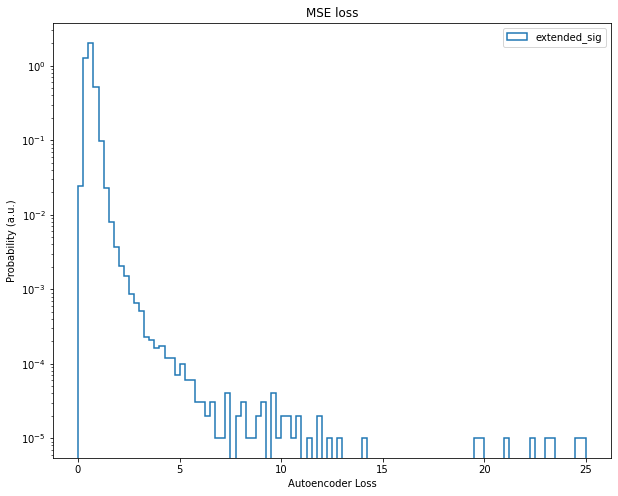

In [21]:
bin_size=100

plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.savefig("dae_layer_16.png")
plt.show()

# 2.

In [21]:
from sklearn.metrics import roc_curve, auc

In [22]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

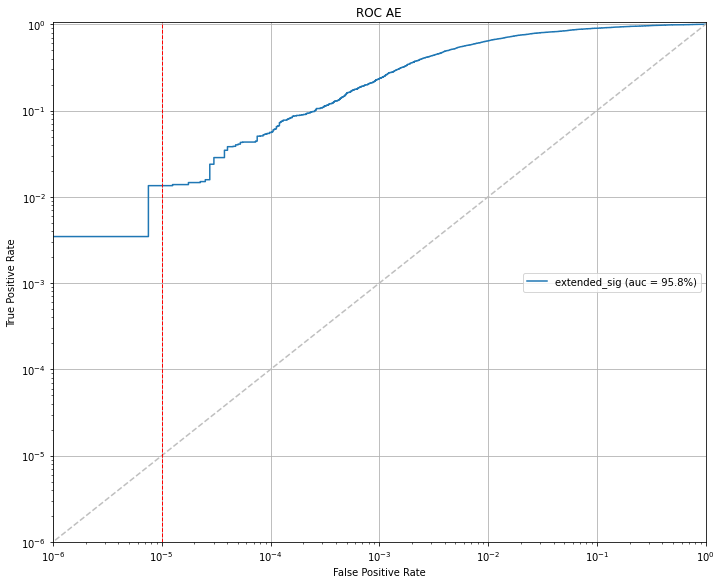

In [24]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.xlim([10**(-6), 1])
plt.ylim([10**(-6), 1.05])
plt.savefig("ROC_correct_particles_56_8")
plt.show()